In [ ]:
import pandas as pd
import numpy as np

# Utils

In [ ]:
def return_ambiguos(df):
    unique_acronyms = df.groupby('Acronym')['Resolution'].nunique()
    ambiguous_acronyms = unique_acronyms[unique_acronyms > 1].index
    ambigous_df = df[df['Acronym'].isin(ambiguous_acronyms)]
    ambigous_df = ambigous_df.sort_values(by='Resolution')
    return ambigous_df

# EDA

In [ ]:
df_sintatic = pd.read_pickle("data/sintetic_wemb_MiniLM_L6_v2.pkl")

In [ ]:
df_sintatic["Acronym"].unique()

In [ ]:
df_sintatic

# Disambiguation 

In [ ]:
from disambiguation import embedding_based_only, jaccard_based

results = {
    "Label": [],
    "Prediction": [],
    "True": [],
}

results = embedding_based_only(df_sintatic, results)
#results = jaccard_based(df_sintatic, results)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Label')



## ensamble

In [ ]:
from disambiguation import embedding_based_only, jaccard_based
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("vladjr/bert-teste3")
model = AutoModelForSequenceClassification.from_pretrained("vladjr/bert-teste3", from_tf=True)

In [ ]:
!transformers-cli convert --model vladjr/bert-teste3

In [ ]:
from transformers import pipeline

pipe = pipeline("text-classification", model="vladjr/bert-teste3")

In [ ]:
results_embedding = {
    "Label": [],
    "Prediction": [],
    "True": [],
}

results_embedding = embedding_based_only(df_sintatic, results_embedding)

results_BERT = {
    "Label": [],
    "Prediction": [],
    "True": [],
}
results_BERT_df = pd.DataFrame(results_BERT).sort_values(by='Label')


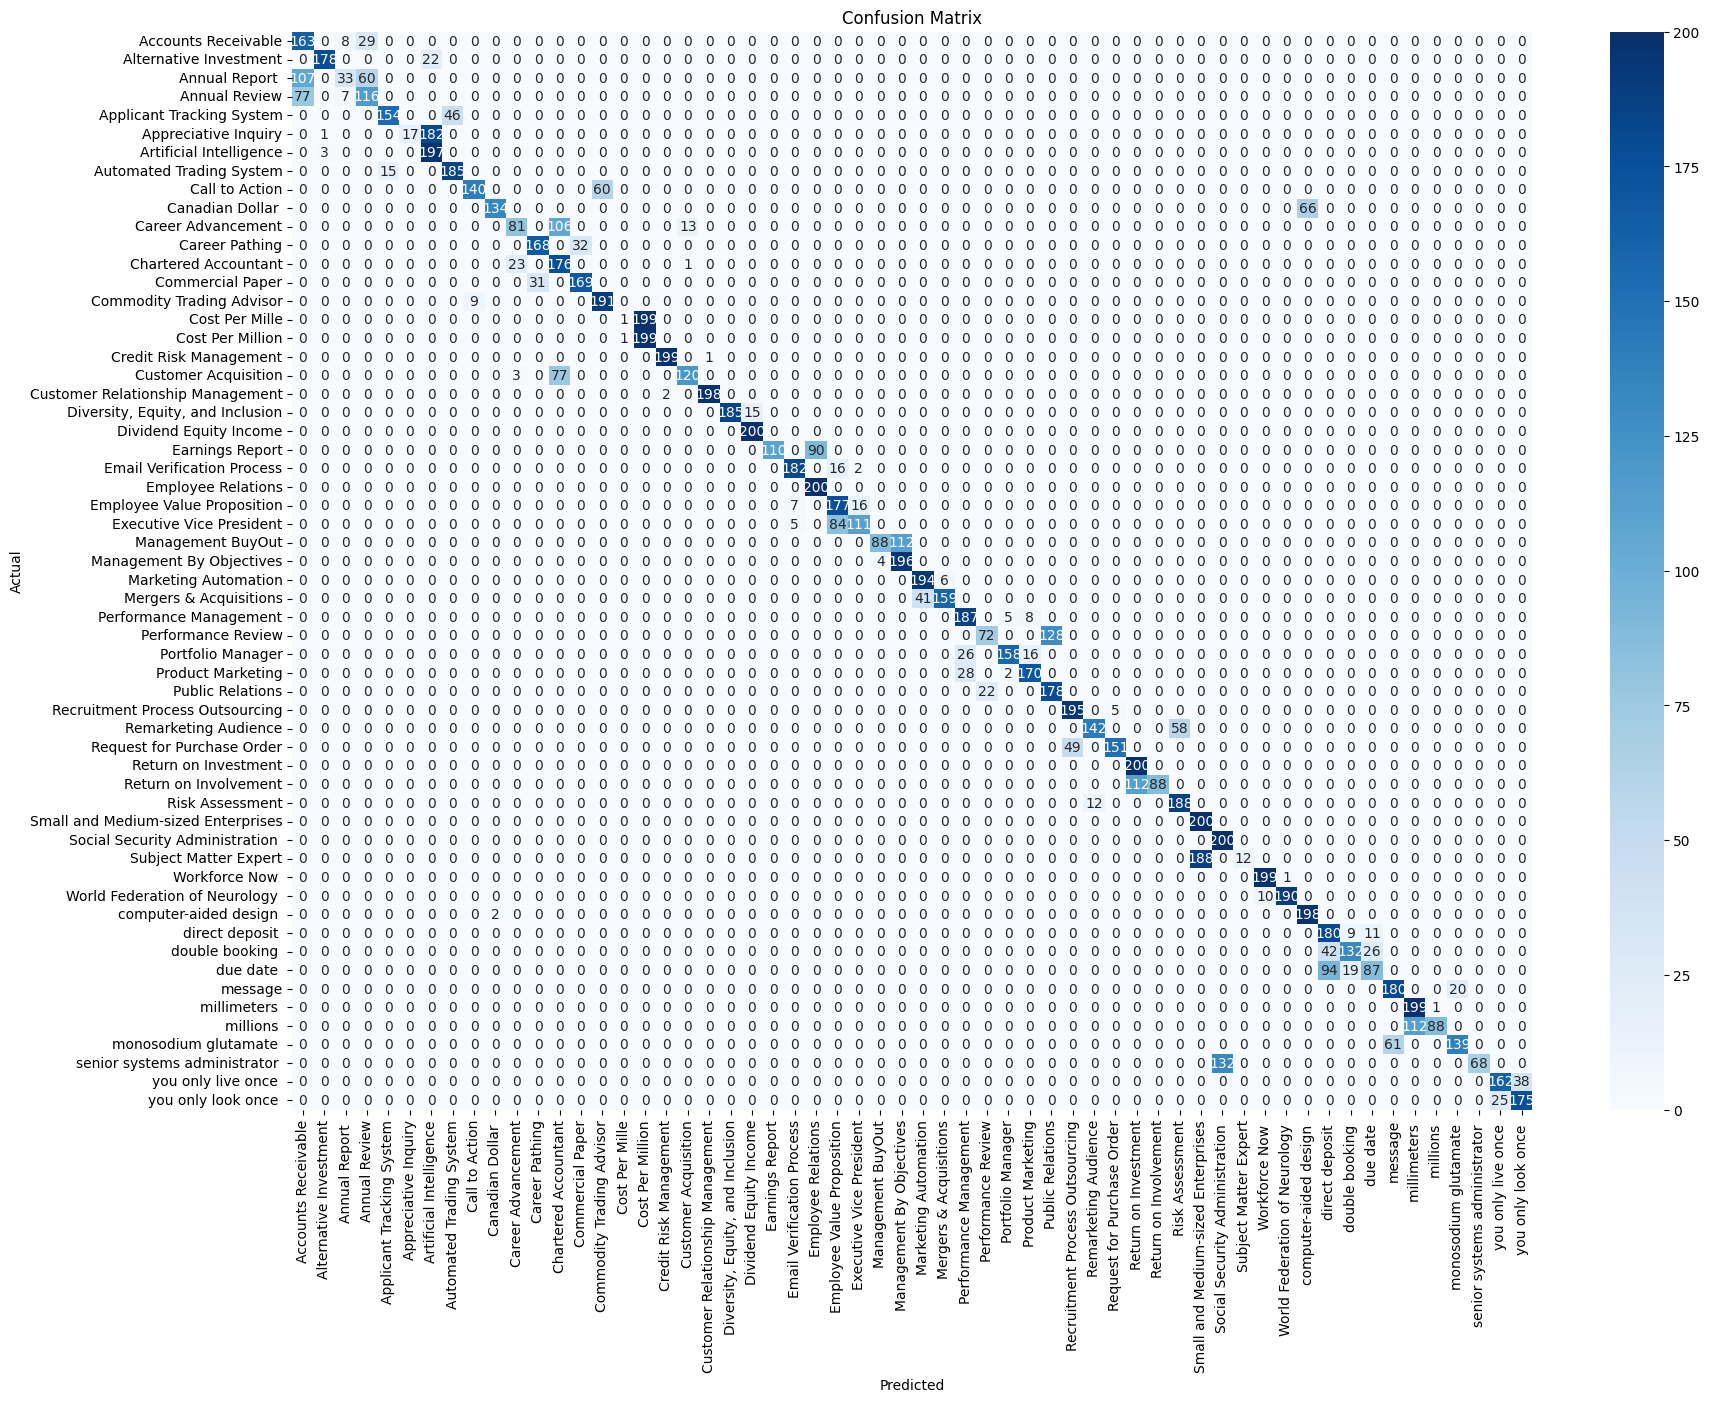

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score
import seaborn as sns

confusion = confusion_matrix(results_df['Label'], results_df['Prediction'])

plt.figure(figsize=(20, 14))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=results_df["Label"].unique(), yticklabels=results_df["Label"].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [11]:
results_df["True"].sum() / len(results_df)

0.7550862068965517

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score

class_labels = results_df['Label'].unique()
precisions = []

for label in class_labels:
    true_labels = results_df['Label'] == label
    predicted_labels = results_df['Prediction'] == label
    precision = precision_score(true_labels, predicted_labels)
    precisions.append(precision)

precision_df = pd.DataFrame({'Class': class_labels, 'Precision': precisions})
precision_df = precision_df.sort_values(by='Precision', ascending=True)

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Class', y='Precision', data=precision_df, palette='Blues')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(rotation=90)
plt.show()


In [ ]:
def calculate_precisions(results_df):
    unique_labels = results_df["Label"].unique()
    precisions = []
    for label in unique_labels:
        true_labels = results_df['Label'] == label
        predicted_labels = results_df['Prediction'] == label
        precision = precision_score(true_labels, predicted_labels)
        precisions.append(precision)
    return unique_labels, precisions

def filter_low_precision_classes(results_df, precisions, threshold=0.70):
    low_precision_classes = [label for label, precision in zip(unique_labels, precisions) if precision >= threshold]
    return results_df[~results_df['Label'].isin(low_precision_classes)]

unique_labels, precisions = calculate_precisions(results_df)
filtered_results_df = filter_low_precision_classes(results_df, precisions, threshold=0.60)

for i, acc_l in enumerate(filtered_results_df["Label"].unique()):
    precision = precisions[list(unique_labels).index(acc_l)]
    print(f"{i+1}. {acc_l}, {precision:.2f}")